With this notebook we want to test how many and which of the important features have been exploited by each isolation tree in a given isolation forest.

In [1]:
import os
import numpy as np
import pickle as pkl 
import matplotlib.pyplot as plt 
%matplotlib inline
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.utils import shuffle
# import shap
# import diffi.interpretability_module as interp
from diffi.utils import *
import wandb

/Users/sebastianosanson/Documents/Master Thesis/Master-Thesis/mt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sanson-sebastiano-00 (sanson-sebastiano-00-universita-di-padova) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Load dataset

In [3]:
with open(os.path.join(os.getcwd(), 'dataset', 'syn_train.pkl'), 'rb') as f:
    data_tr = pkl.load(f)
with open(os.path.join(os.getcwd(), 'dataset', 'syn_test.pkl'), 'rb') as f:
    data_te = pkl.load(f)

X_tr = data_tr.iloc[:, :-1]
y_tr = data_tr.iloc[:, -1]

X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

X_te = data_te.iloc[:, :-1]
y_te = data_te.iloc[:, -1]


In [4]:
print('Training set size: ', X_tr.shape)
print('Trainin label size: ', y_tr.shape)

print('Test set size: ', X_te.shape)
print('Test label size: ', y_te.shape)

Training set size:  (1000, 20)
Trainin label size:  (1000,)
Test set size:  (100, 20)
Test label size:  (100,)


## Train the Isolation Forest

Parameters for the model

In [5]:
num_trees = 100
max_samples = 256
n_forests = 1
contamination = 0.1
usage_threshold = 0.20
# total_runs = 10

In [6]:
# Init wandb to log the results
run = wandb.init(
    project="diffi_optimization",
    name=f"experiment_forest_{n_forests}_trees_{num_trees}_threshold_{usage_threshold}",
    # job_type="training",
    config={
        "num_trees": num_trees,
        "max_samples": max_samples,
        "n_forests": n_forests,
        "contamination": contamination,
        "usage_threshold": usage_threshold,
    }
)

Training of the model and getting the values from DIFFI's method

In [7]:
sorted_idx, avg_f1, fi_means, fi_std, features_per_forest, fi_diffi_all, iforests, fi_diffi_inliers, fi_diffi_outliers = diffi_ranks_per_tree(X=X_tr.to_numpy(), y=y_tr.to_numpy(), n_trees=run.config.num_trees,
                                                                         max_samples=run.config.max_samples, n_iter=run.config.n_forests, contamination=run.config.contamination) 

In [8]:
# Log the configuration of parameters
config_data = [
    ["num_trees", num_trees],
    ["max_samples", max_samples],
    ["n_forests", n_forests],
    ["contamination", contamination],
    ["usage_threshold", usage_threshold],
]

config_table = wandb.Table(data=config_data, columns=["Parameter", "Value"])

run.log({"Configuration Table": config_table})

In [9]:
print('Original Average F1 score: {:.4f}'.format(avg_f1))

Original Average F1 score: 0.4300


In [10]:
print('shape of fi_diffi_inliers: ', fi_diffi_inliers.shape)
print('shape of fi_diffi_outliers: ', fi_diffi_outliers.shape)

shape of fi_diffi_inliers:  (1, 100, 20)
shape of fi_diffi_outliers:  (1, 100, 20)


## Feature importance

In [11]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Bar(
#     x=list(range(len(sorted_idx))),
#     y=fi_means[sorted_idx],
#     error_y=dict(type='data', array=fi_std[sorted_idx]),
#     name='Feature Importance'
# ))

# fig.update_layout(
#     xaxis=dict(title='Feature index', tickmode='array', tickvals=list(range(len(sorted_idx))), ticktext=sorted_idx),
#     yaxis=dict(title='Feature importance'),
#     title='Feature Importance'
# )

# wandb.log({"feature_importance_plot": fig})
# fig.show()

In [12]:

# feature_names = [str(idx) for idx in sorted_idx]
# run.log({
#     "feature_importance": wandb.plot.bar(
#         wandb.Table(
#             data=[[name, mean] for name, mean in zip(feature_names, fi_means[sorted_idx])],
#             columns=["Feature", "Importance"]
#         ),
#         "Feature",
#         "Importance",
#         title="Feature Importance",
#     )
# })

Plotting the feature importance values for each feature

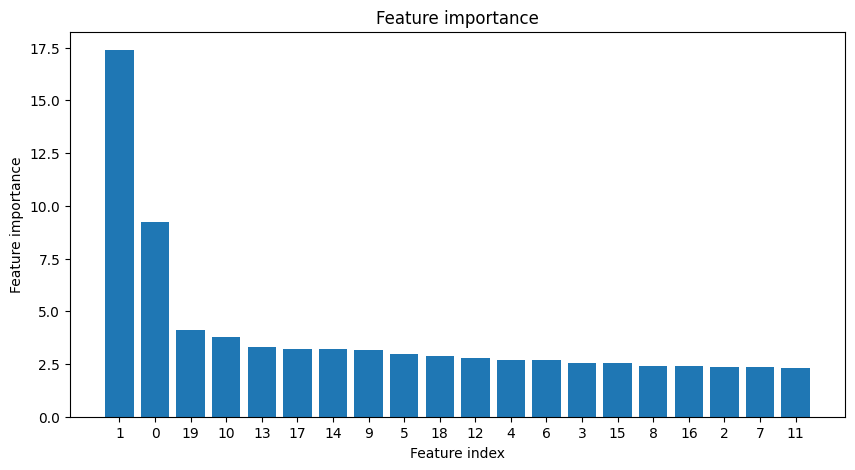

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx)), fi_means[sorted_idx], yerr=fi_std[sorted_idx])
plt.xticks(range(len(sorted_idx)), sorted_idx)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importance')

run.log({"feature_importance_image": wandb.Image(plt)})

plt.show()

Notice that the most important features are the meaningful ones, while the other are the noise ones.

In [14]:
most_important_features = sorted_idx[:2]
print('Most important features:', most_important_features)

Most important features: [1 0]


## Feature importance for each tree

Plotting the heatmap of feature importance for every trees 

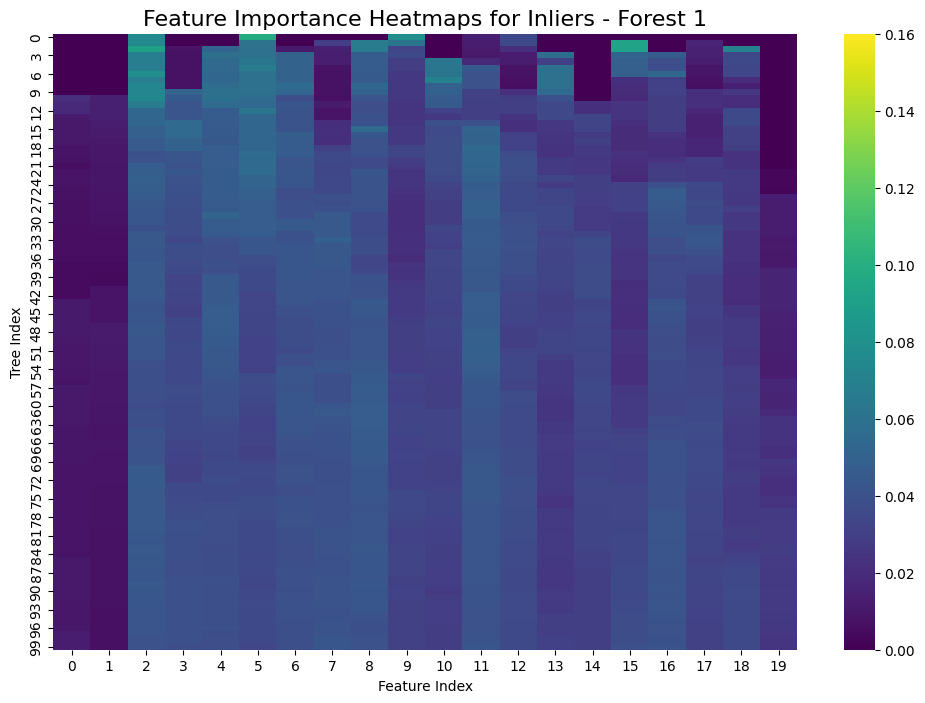

In [15]:
import seaborn as sns

for i, forest in enumerate(fi_diffi_inliers):
    plt.figure(figsize=(12, 8))
    plt.plot(1, len(fi_diffi_inliers), i + 1)
    sns.heatmap(forest, cmap='viridis', cbar=True, vmin=0, vmax=0.16)
    plt.xlabel('Feature Index')
    plt.ylabel('Tree Index')
    # plt.tight_layout()
    plt.title(f'Feature Importance Heatmaps for Inliers - Forest {i + 1}', fontsize=16)

    run.log({"feature_importance_heatmap_inliers": wandb.Image(plt)})

    plt.show()

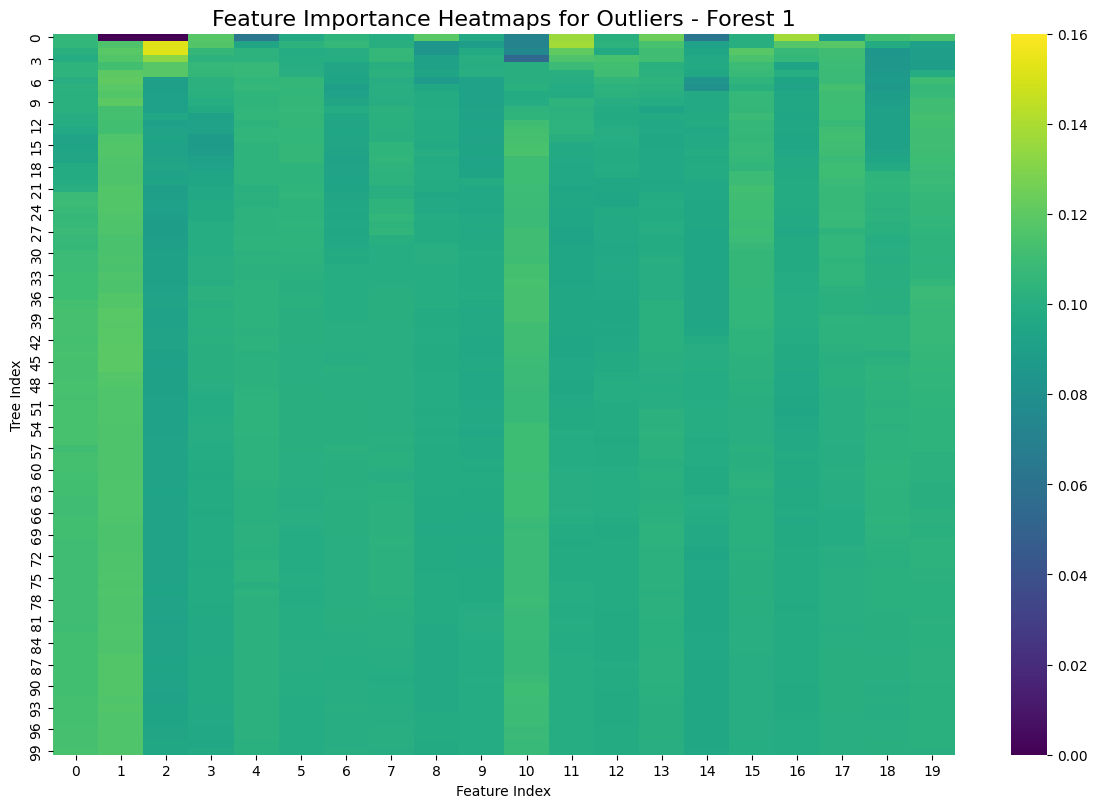

In [16]:
for i, forest in enumerate(fi_diffi_outliers):
    plt.figure(figsize=(12, 8))
    plt.plot(1, len(fi_diffi_outliers), i + 1)
    sns.heatmap(forest, cmap='viridis', cbar=True, vmin=0, vmax=0.16)
    plt.xlabel('Feature Index')
    plt.ylabel('Tree Index')
    plt.tight_layout()
    plt.title(f'Feature Importance Heatmaps for Outliers - Forest {i + 1}', fontsize=16)

    run.log({"feature_importance_heatmap_outliers": wandb.Image(plt)})

    plt.show()

## Global features usage in Isolation Forest

We compute the usage of each feature over the isolation forests of the model

In [17]:
usage_per_forest = np.zeros((len(features_per_forest), X_tr.shape[1]), 
                            dtype=object)    # shape: (number of forests, number of features)
usage_per_tree = np.zeros((len(features_per_forest), len(features_per_forest[0]), X_tr.shape[1]), 
                          dtype=object)  # shape: (number of forests, number of trees, number of features)


for i in range(X_tr.shape[1]):                                                      # for each feature                                     
    for j, forest in enumerate(features_per_forest):                                # for each forest
        for k, tree in enumerate(forest):                                           # for each tree
            # count the number of times feature i is used in tree k in forest j
            usage_per_tree[j, k, i] = np.sum([1 for feature in tree if feature == i])   
        # count the number of times feature i is used in forest j
        usage_per_forest[j, i] = np.sum(usage_per_tree[j, :, i])                          

# print(np.array(usage_per_forest, dtype=object).shape)
# print(np.array(usage_per_tree, dtype=object).shape)

In [18]:
# data = []
# column_names = ["Forest", "Feature_Index", "Usage_Count"]

# for forest_idx in range(usage_per_forest.shape[0]):
#     for feature_idx in range(usage_per_forest.shape[1]):
#         data.append([f"Forest {forest_idx+1}", feature_idx, int(usage_per_forest[forest_idx, feature_idx])])

# table = wandb.Table(data=data, columns=column_names)

# run.log({
#     "feature_usage": wandb.plot.bar(
#         table, 
#         "Feature_Index", 
#         "Usage_Count",
#         title="Feature Usage Across Forests",
#     )
# })

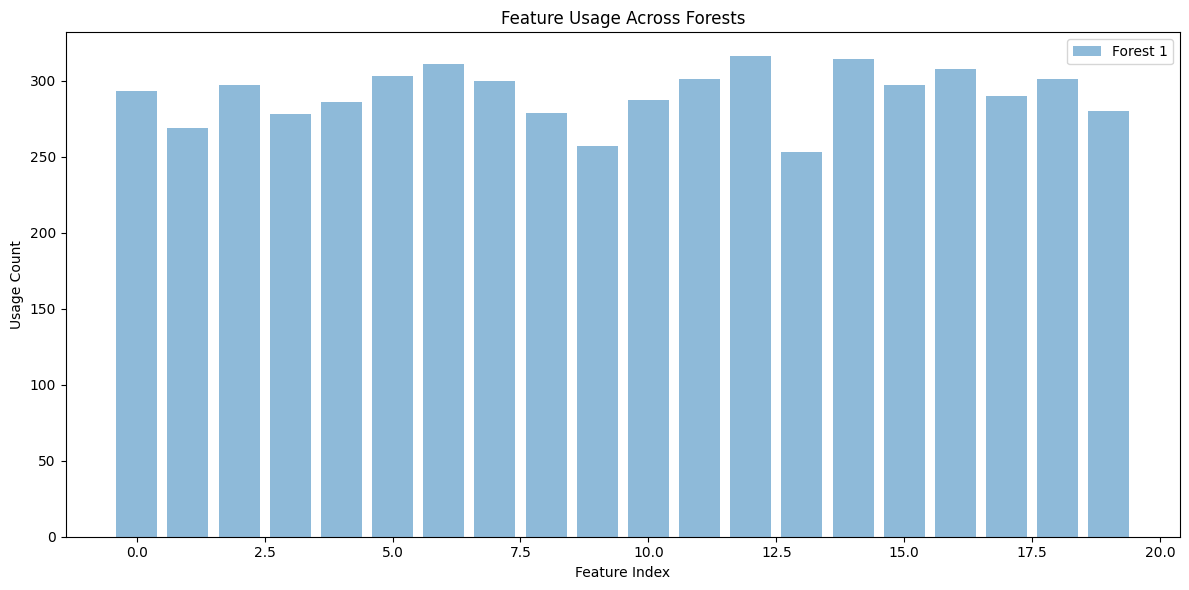

In [19]:
plt.figure(figsize=(12, 6))
for i in range(usage_per_forest.shape[0]):
    plt.bar(range(usage_per_forest.shape[1]), usage_per_forest[i], alpha=0.5, label=f'Forest {i+1}')
plt.xlabel('Feature Index')
plt.ylabel('Usage Count')
plt.title('Feature Usage Across Forests')
plt.legend()
plt.tight_layout()

run.log({"feature_usage_image": wandb.Image(plt)})

plt.show()

## `most_important_features` usage 

Counting how many times the `most_important_features`are used in each Isolation Tree

In [20]:
num_forests = len(features_per_forest)
num_trees = len(features_per_forest[0])

most_important_features_usage = np.zeros((len(most_important_features), 
                                              num_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)
# print(most_important_features_usage.shape)

for i in range(len(most_important_features)):
    for j, forest in enumerate(features_per_forest):
        for k, tree in enumerate(forest):
            most_important_features_usage[i, j, k] = usage_per_tree[j, k, i] / len(tree)  

print('Two most important features usage:', most_important_features_usage)

Two most important features usage: [[[0.02857143 0.03007519 0.02721088 0.01123596 0.03870968 0.
   0.03508772 0.04316547 0.02521008 0.         0.00826446 0.01438849
   0.00917431 0.01886792 0.04511278 0.01481481 0.03076923 0.00613497
   0.03546099 0.         0.00840336 0.05035971 0.06060606 0.01574803
   0.01769912 0.06766917 0.02013423 0.02857143 0.01863354 0.05405405
   0.05426357 0.02105263 0.         0.01204819 0.01265823 0.
   0.01694915 0.02597403 0.03738318 0.         0.04       0.03448276
   0.04273504 0.0173913  0.02484472 0.01960784 0.         0.00740741
   0.01459854 0.04137931 0.02362205 0.02752294 0.02040816 0.01204819
   0.02298851 0.02197802 0.01438849 0.03184713 0.01834862 0.04242424
   0.00826446 0.04065041 0.         0.04026846 0.07070707 0.01869159
   0.00787402 0.03589744 0.00564972 0.0130719  0.016      0.04458599
   0.01098901 0.         0.02362205 0.03296703 0.01459854 0.04761905
   0.03007519 0.0173913  0.02247191 0.01818182 0.02923977 0.02247191
   0.01910828 0

Now we are going to normalize the results to the range [0, 1]

In [21]:
most_important_features_usage_percentage = np.zeros((len(most_important_features), 
                                                            num_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)

for i, feature in enumerate(most_important_features_usage):
    for j, forest in enumerate(feature):
        max = np.max(forest)
        for k, tree in enumerate(forest):
            most_important_features_usage_percentage[i, j, k] = most_important_features_usage[i, j, k] / max

print('Two most important features usage percentage:', most_important_features_usage_percentage)

Two most important features usage percentage: [[[0.40408163 0.42534909 0.38483965 0.15890851 0.54746544 0.
   0.4962406  0.61048304 0.35654262 0.         0.11688312 0.20349435
   0.12975098 0.26684636 0.63802363 0.20952381 0.43516484 0.08676599
   0.50151976 0.         0.11884754 0.71223022 0.85714286 0.22272216
   0.25031606 0.95703545 0.28475551 0.40408163 0.2635315  0.76447876
   0.76744186 0.29774436 0.         0.17039587 0.17902351 0.
   0.23970944 0.36734694 0.52870494 0.         0.56571429 0.48768473
   0.6043956  0.24596273 0.35137533 0.27731092 0.         0.1047619
   0.20646507 0.58522167 0.33408324 0.38925295 0.28862974 0.17039587
   0.32512315 0.31083203 0.20349435 0.45040946 0.25950197 0.6
   0.11688312 0.57491289 0.         0.56951103 1.         0.26435247
   0.11136108 0.50769231 0.07990315 0.18487395 0.22628571 0.63057325
   0.15541601 0.         0.33408324 0.46624804 0.20646507 0.67346939
   0.42534909 0.24596273 0.31781701 0.25714286 0.41353383 0.31781701
   0.2702456

Plotting the percentage of usage of `most_important_features` across isolation trees

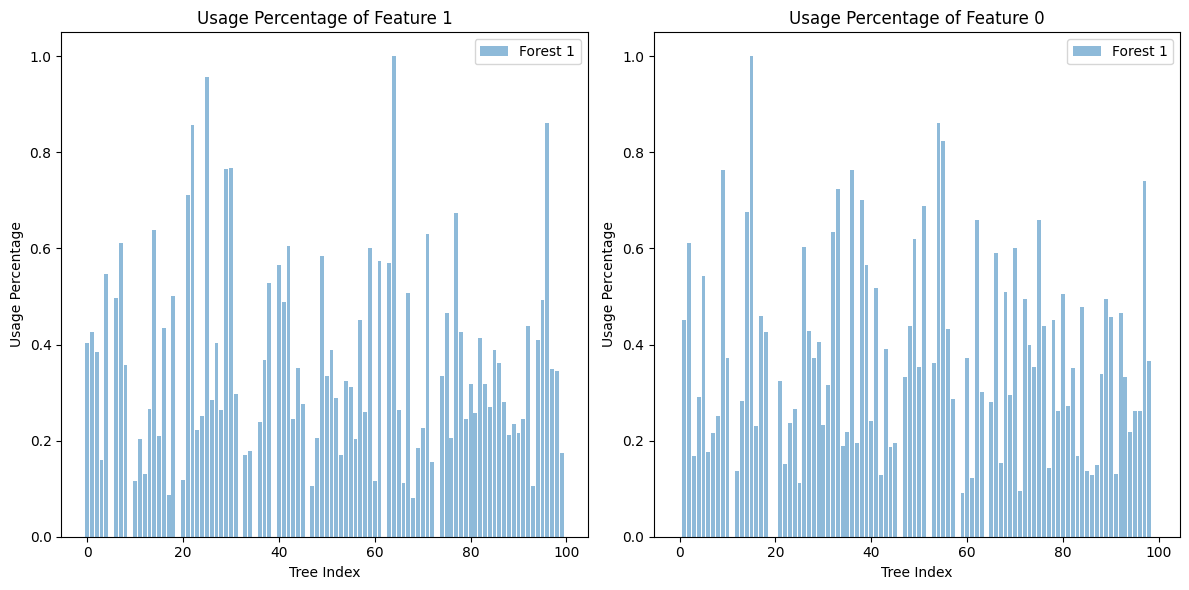

In [22]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(most_important_features):
    plt.subplot(1, 2, i+1)
    for j in range(num_forests):
        plt.bar(range(num_trees), most_important_features_usage_percentage[i, j, :], alpha=0.5, label=f'Forest {j+1}')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Percentage')
    plt.title(f'Usage Percentage of Feature {feature}')
    plt.legend()
plt.tight_layout()

run.log({"most_important_features_usage_image": wandb.Image(plt)})

plt.show()

## Average usage

Calculating the average of the `most_important_features_usage_percentage` for each `most_important_features`

In [23]:
average_usage_percentage = np.zeros((len(most_important_features), num_forests))    # shape: (number of meaningful features, number of forests)
for i in range(len(most_important_features)):
    for j in range(num_forests):
        average_usage_percentage[i, j] = np.mean(most_important_features_usage_percentage[i, j, :])
print('Average usage percentage:', average_usage_percentage)

Average usage percentage: [[0.33582968]
 [0.34879514]]


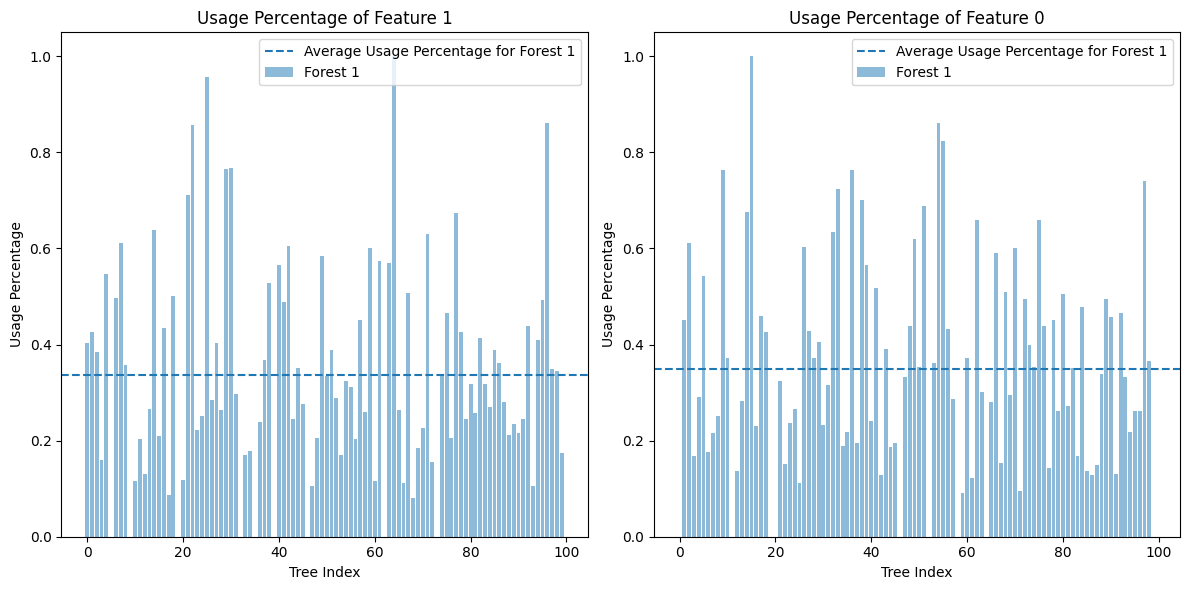

In [24]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(most_important_features):
    plt.subplot(1, 2, i+1)
    for j in range(num_forests):
        plt.bar(range(num_trees), most_important_features_usage_percentage[i, j, :], alpha=0.5, label=f'Forest {j+1}')
        plt.axhline(y=average_usage_percentage[i, j], color=f'C{j}', linestyle='--', label=f'Average Usage Percentage for Forest {j+1}')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Percentage')
    plt.title(f'Usage Percentage of Feature {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

## Inference on new iForests

Now we are going to select the indexes of the trees to be removed from the original iForests

In [25]:
# save indexes of the trees to be removed
tree_idx = np.zeros((len(most_important_features), num_forests), dtype=object)  # shape: (number of meaningful features, number of forests)
print(tree_idx.shape)

for i, feature in enumerate(most_important_features_usage_percentage):
    for j, forest in enumerate(feature):
        tree_idx[i, j] = np.where(forest < run.config.usage_threshold)[0]  # get the indexes of the trees where the usage percentage is less than usage_threshold
        print(f"Feature {most_important_features[i]} in Forest {j+1} has trees with usage percentage < {run.config.usage_threshold}: {tree_idx[i, j]}")


(2, 1)
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 3  5  9 10 12 17 19 20 32 33 34 35 39 46 47 53 60 62 66 68 69 72 73 93
 99]
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [ 0  3  6 11 12 19 20 22 25 34 37 42 44 45 46 52 58 59 61 64 67 71 77 83
 85 86 87 91 99]


Concatenating and removing the duplicates

In [26]:
tree_to_be_removed = np.zeros(num_forests, dtype=object)
print(tree_to_be_removed.shape)

for i in range(num_forests):
    # concatenate the indexes of the trees to be removed for each feature
    concatenated = np.concatenate(([feature[i] for feature in tree_idx]), axis=0)
    # print('concatenated: {}'.format(concatenated))
    # remove duplicates
    concatenated = np.unique(concatenated)
    # print('unique: {}'.format(concatenated))
    tree_to_be_removed[i] = concatenated

print(tree_to_be_removed)
print('Number of trees to be removed: ', [len(tree_to_be_removed[i]) for i in range(len(tree_to_be_removed))])

(1,)
[array([ 0,  3,  5,  6,  9, 10, 11, 12, 17, 19, 20, 22, 25, 32, 33, 34, 35,
        37, 39, 42, 44, 45, 46, 47, 52, 53, 58, 59, 60, 61, 62, 64, 66, 67,
        68, 69, 71, 72, 73, 77, 83, 85, 86, 87, 91, 93, 99])               ]
Number of trees to be removed:  [47]


Removing the trees selected from the original iForests

In [27]:
for i, forest in enumerate(iforests):
    # print(f'Forest {i}:')
    
    # Get the list of trees and their corresponding features
    trees = forest.estimators_
    features = forest.estimators_features_

    # print(' Number of trees before removal:', len(trees))
    # print(' Number of features in trees before removal:', len(features))
    
    # Remove the specified trees and their features
    trees_to_keep = [tree for idx, tree in enumerate(trees) if idx not in tree_to_be_removed[i]]
    features_to_keep = [feature for idx, feature in enumerate(features) if idx not in tree_to_be_removed[i]]
    
    # Update the forest with the filtered lists
    forest.estimators_ = trees_to_keep
    forest.estimators_features_ = features_to_keep

    # Update internal attributes to match the reduced number of trees
    forest._decision_path_lengths = [forest._decision_path_lengths[idx] for idx in range(len(trees)) if idx not in tree_to_be_removed[i]]
    forest._average_path_length_per_tree = [forest._average_path_length_per_tree[idx] for idx in range(len(trees)) if idx not in tree_to_be_removed[i]]
    
    # print(' Number of trees after removal:', len(forest.estimators_))
    # print(' Number of features after removal:', len(forest.estimators_features_))

In [28]:
print('Number of trees after removal: ', [len(iforests[i].estimators_) for i in range(len(iforests))])
print('Number of features in trees after removal: ', [len(iforests[i].estimators_features_) for i in range(len(iforests))])
print('Number of decision path lengths after removal: ', [len(iforests[i]._decision_path_lengths) for i in range(len(iforests))])
print('Number of average path lengths after removal: ', [len(iforests[i]._average_path_length_per_tree) for i in range(len(iforests))])

Number of trees after removal:  [53]
Number of features in trees after removal:  [53]
Number of decision path lengths after removal:  [53]
Number of average path lengths after removal:  [53]


Performing inference on new iForests

In [29]:
new_sorted_idx, new_avg_f1, new_fi_means, new_fi_std, new_features_per_forest, new_fi_diffi_all, new_fi_diffi_inliers, new_fi_diffi_outliers = diffi_ranks_evaluation_only(X=X_tr.to_numpy(), y=y_tr.to_numpy(), iforest=iforests) 

print('New average F1 score: {:.4f}'.format(new_avg_f1))

#TODO: check new_fi_diffi_inliers, new_fi_diffi_outliers

New average F1 score: 0.4766


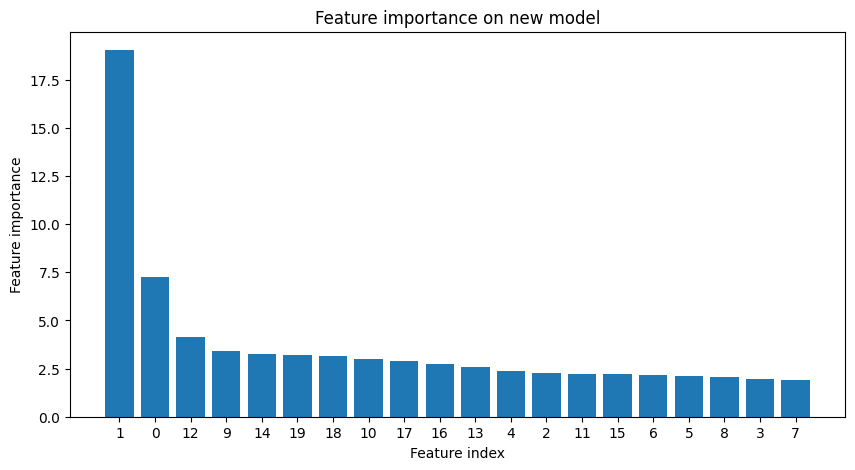

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(new_sorted_idx)), new_fi_means[new_sorted_idx], yerr=new_fi_std[new_sorted_idx])
plt.xticks(range(len(new_sorted_idx)), new_sorted_idx)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importance on new model')

# run.log({"new_feature_importance_image": wandb.Image(plt)})

plt.show()

In [31]:
data = [[f"Forest {i+1}", len(iforests[i].estimators_)] for i in range(len(iforests))]
columns = ["Forest", "Number of Estimators"]

num_estimators_table = wandb.Table(data=data, columns=columns)

run.log({"Number of Estimators Table in the new model": num_estimators_table})

In [32]:
# Log the F1 scores
data = [[num_forests, avg_f1, new_avg_f1]]
columns = ["Forest", "Original F1 Score", "New F1 Score"]

avg_f1_scores_table = wandb.Table(data=data, columns=columns)

run.log({
    "F1 Scores Table": avg_f1_scores_table
})

In [33]:
# for idx in sorted_idx:
#     print(f"Feature {idx}: {fi_means[idx]}")

In [34]:
# for idx in new_sorted_idx:
#     print(f"Feature {idx}: {new_fi_means[idx]}")

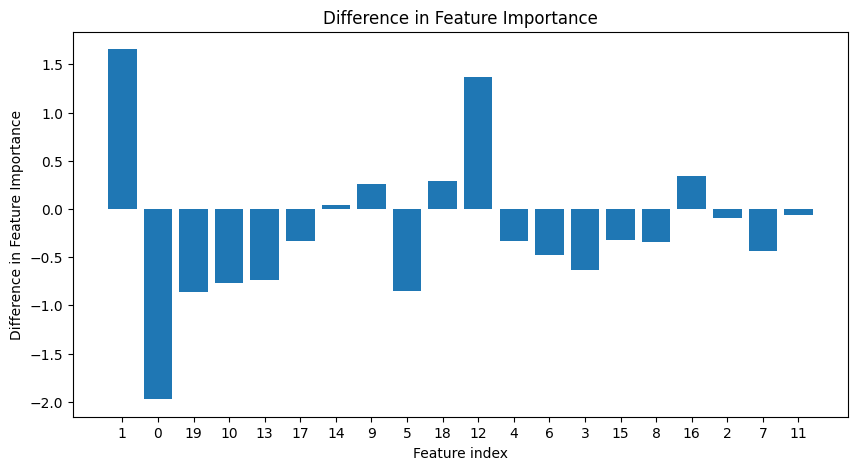

In [35]:
diff = []
for idx in sorted_idx:
    diff.append(new_fi_means[idx] - fi_means[idx])
    
plt.figure(figsize=(10, 5))
plt.bar(range(len(diff)), diff)
plt.xticks(range(len(diff)), sorted_idx)
plt.xlabel('Feature index')
plt.ylabel('Difference in Feature Importance')
plt.title('Difference in Feature Importance')
# run.log({"difference_feature_importance_image": wandb.Image(plt)})
plt.show()

In [36]:
run.finish()